In [1]:
!wget https://trello-attachments.s3.amazonaws.com/60184d6ad9df212c4ec2f00e/60186ca0fbf89186ae26f0cb/230843f1aa94c637870126a4fb792ee5/final_data.csv.zip

--2021-04-21 06:52:54--  https://trello-attachments.s3.amazonaws.com/60184d6ad9df212c4ec2f00e/60186ca0fbf89186ae26f0cb/230843f1aa94c637870126a4fb792ee5/final_data.csv.zip
Resolving trello-attachments.s3.amazonaws.com (trello-attachments.s3.amazonaws.com)... 52.217.101.108
Connecting to trello-attachments.s3.amazonaws.com (trello-attachments.s3.amazonaws.com)|52.217.101.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9268933 (8.8M) [application/zip]
Saving to: ‘final_data.csv.zip’

final_data.csv.zip  100%[===================>]   8.84M  30.0MB/s    in 0.3s    

2021-04-21 06:52:55 (30.0 MB/s) - ‘final_data.csv.zip’ saved [9268933/9268933]



In [2]:
!unzip final_data.csv.zip

Archive:  final_data.csv.zip
  inflating: final_data.csv          


In [1]:
!pip install tqdm

In [2]:
!pip install torch

In [3]:
!pip install transformers

     |████████████████████████████████| 2.1 MB 5.8 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 36.6 MB/s eta 0:00:01
     |████████████████████████████████| 895 kB 65.3 MB/s eta 0:00:01


In [4]:
import random
import os
import sys
# science
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
# process
import joblib
from tqdm import tqdm
from functools import partial
# ml
import torch
from transformers import AutoModel, AutoTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from joblib import dump, load
import gc 
import time
import pickle
from sklearn.cluster import KMeans

In [5]:
SEED = 42


 """
 Ensure same seed for reproducibility
 
 """
    
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [6]:
"""
Add Kmeans labels for feature engineering
"""
KMEANS = False

In [7]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [8]:
df = pd.read_csv('final_data.csv')
df.head(3)

,ICD Block Names,Title,Research Summary,Inclusion Criteria
0,Abnormal findings on diagnostic imaging and in...,Checkpoint inhibitor-induced liver injury (ChI...,â¢ Immune checkpoint inhibitors are proven ca...,Both patient groups and control group: Aged 1...
1,"Abnormal findings on examination of blood, wit...",Exploring the patient experience of a diagnosi...,Research Question: Exploring the patient exper...,â Coded diagnosis of pre-diabetes and have b...
2,"Abnormal findings on examination of blood, wit...",Assessment of the Impact of a Personalised Nut...,This study will determine if DNA-based dietary...,In order to be eligible to participate in this...


In [9]:
true_labels = df["ICD Block Names"] 

In [10]:
"""
Choose the number of labels to keep
"""
labels_to_keep = []
for i in true_labels.value_counts().index:
    if true_labels.value_counts()[i] >= 0 : 
        labels_to_keep.append(i)
labels_to_keep = list(set(labels_to_keep))

In [11]:
df = df[df["ICD Block Names"].isin(labels_to_keep)]

In [12]:
content = df[["Title","Research Summary","Inclusion Criteria"]].values.T.astype(str)
title_content, abstract_content, inclusion_content = content[0], content[1], content[2] 

In [13]:
labels_to_keep = ['Chronic lower respiratory diseases',
 'Congenital malformations of the urinary system',
 'Malignant neoplasms of mesothelial and soft tissue',
 'Other congenital malformations of the digestive system',
 'Bacterial agents resistant to antibiotics',
 'Protozoal diseases',
 'Other diseases of upper respiratory tract',
 'Mental retardation',
 'Malignant neoplasm of breast',
 'Other disorders of the skin and subcutaneous tissue',
 'Behavioural and emotional disorders with onset usually occurring in childhood and adolescence',
 'Malignant neoplasms of eye, brain and other parts of central nervous system',
 'Organic, including symptomatic, mental disorders',
 'Other diseases of urinary system',
 'Other land transport accidents',
 'Inflammatory polyarthropathies',
 'Disorders of skin appendages',
 'Spondylopathies',
 'Accidental poisoning by and exposure to noxious substances',
 'Congenital malformations of the circulatory system',
 'Congenital malformations of genital organs',
 'Disorders of adult personality and behaviour',
 'Injuries to the abdomen, lower back, lumbar spine and pelvis',
 'Other diseases of the respiratory system',
 'Infections specific to the perinatal period',
 'Digestive system disorders of fetus and newborn',
 'Diseases of arteries, arterioles and capillaries',
 'Other osteopathies',
 'Unspecified mental disorder',
 'Delivery',
 'Injuries to the hip and thigh',
 'Noninflammatory disorders of female genital tract',
 'Persons with potential health hazards related to socioeconomic and psychosocial circumstances',
 'Symptoms and signs involving the skin and subcutaneous tissue',
 'Congenital malformations of the respiratory system',
 'Other disorders of kidney and ureter',
 'Papulosquamous disorders',
 'Surgical and other medical procedures as the cause of abnormal reaction of the patient, or of later complication, without mention of misadventure at the time of the procedure',
 'Disorders of other endocrine glands',
 'Cerebrovascular diseases',
 'Oedema, proteinuria and hypertensive disorders in pregnancy, childbirth and the puerperium',
 'Symptoms and signs involving speech and voice',
 'Diseases of middle ear and mastoid',
 'Neurotic, stress-related and somatoform disorders',
 'Falls',
 'Malignant neoplasms of respiratory and intrathoracic organs',
 'Other disorders of the genitourinary system',
 'Inflammatory diseases of female pelvic organs',
 'Deforming dorsopathies',
 'Other viral diseases',
 'Other disorders of the musculoskeletal system and connective tissue',
 'Obesity and other hyperalimentation',
 'Complications of surgical and medical care, not elsewhere classified',
 'Neoplasms of uncertain or unknown behaviour',
 'Chromosomal abnormalities, not elsewhere classified',
 'Mycoses',
 'Cleft lip and cleft palate',
 'Infectious arthropathies',
 'Other infectious diseases',
 'Sequelae of infectious and parasitic diseases',
 'Disorders of optic nerve and visual pathways',
 'Systemic connective tissue disorders',
 'Viral hepatitis',
 'Toxic effects of substances chiefly nonmedicinal as to source',
 'Viral infections characterized by skin and mucous membrane lesions',
 'Chondropathies',
 'Disorders of choroid and retina',
 'Visual disturbances and blindness',
 'Diseases of peritoneum',
 'Other acute lower respiratory infections',
 'Other disorders of ear',
 'Persons with potential health hazards related to family and personal history and certain conditions influencing health status',
 'Symptoms and signs involving cognition, perception, emotional state and behaviour',
 'Conditions involving the integument and temperature regulation of fetus and newborn',
 'Coagulation defects, purpura and other haemorrhagic conditions',
 'Ill-defined and unknown causes of mortality',
 'Malignant neoplasms of bone and articular cartilage',
 'Disorders of thyroid gland',
 'Legal intervention and operations of war',
 'Injuries to the neck',
 'Other disorders of the nervous system',
 'Other joint disorders',
 'Disorders of lens',
 'Certain early complications of trauma',
 'Other disorders of glucose regulation and pancreatic internal secretion',
 'Nerve, nerve root and plexus disorders',
 'Malignant neoplasms of male genital organs',
 'Metabolic disorders',
 'Diseases of oesophagus, stomach and duodenum',
 'Other dorsopathies',
 'Haemorrhagic and haematological disorders of fetus and newborn',
 'Injuries to the head',
 'Mood [affective] disorders',
 'Other and unspecified disorders of the circulatory system',
 'Glaucoma',
 'Inflammatory diseases of the central nervous system',
 'General symptoms and signs',
 'Intentional self-harm',
 'Diseases of appendix',
 'Sequelae of external causes of morbidity and mortality',
 'Disorders of conjunctiva',
 'Ischaemic heart diseases',
 'Diseases of male genital organs',
 'Glomerular diseases',
 'Diabetes mellitus',
 'Other degenerative diseases of the nervous system',
 'Other diseases of intestines',
 'Pedal cyclist injured in transport accident',
 'Urolithiasis',
 'Persons encountering health services in circumstances related to reproduction',
 'Other disorders of eye and adnexa',
 'In situ neoplasms',
 'Disorders related to length of gestation and fetal growth',
 'Malignant neoplasms, stated or presumed to be primary, of lymphoid, haematopoietic and related tissue',
 'Provisional assignment of new diseases of uncertain etiology',
 'Other diseases of pleura',
 'Sequelae of injuries, of poisoning and of other consequences of external causes',
 'Malignant neoplasms of urinary tract',
 'Burns and corrosions of external body surface, specified by site',
 'Certain disorders involving the immune mechanism',
 'Diseases of liver',
 'Diseases of veins, lymphatic vessels and lymph nodes, not elsewhere classified',
 'Disorders of sclera, cornea, iris and ciliary body',
 'Disorders of breast',
 'Pulmonary heart disease and diseases of pulmonary circulation',
 'Viral infections of the central nervous system',
 'Other diseases of blood and blood-forming organs',
 'Dermatitis and eczema',
 'Malignant neoplasms of digestive organs',
 'Other bacterial diseases',
 'Diseases of myoneural junction and muscle',
 'Renal tubulo-interstitial diseases',
 'Disorders of gallbladder, biliary tract and pancreas',
 'Schizophrenia, schizotypal and delusional disorders',
 'Episodic and paroxysmal disorders',
 'Other spirochaetal diseases',
 'Diseases of oral cavity, salivary glands and jaws',
 'Disorders of psychological development',
 'Extrapyramidal and movement disorders',
 'Influenza and pneumonia',
 'Acute upper respiratory infections',
 'Hernia',
 'Disorders of eyelid, lacrimal system and orbit',
 'Abnormal findings on examination of blood, without diagnosis',
 'Persons encountering health services for examination and investigation',
 'Complications predominantly related to the puerperium',
 'Effects of foreign body entering through natural orifice',
 'Injuries to the wrist and hand',
 'Other soft tissue disorders',
 'Other disorders originating in the perinatal period',
 'Malignant neoplasms of thyroid and other endocrine glands',
 'Noninfective enteritis and colitis',
 'Renal failure',
 'Symptoms and signs involving the nervous and musculoskeletal systems',
 'Injuries to unspecified part of trunk, limb or body region',
 'Other congenital malformations',
 'Disorders of ocular muscles, binocular movement, accommodation and refraction',
 'Maternal care related to the fetus and amniotic cavity and possible delivery problems',
 'Pregnancy with abortive outcome',
 'Benign neoplasms',
 'Suppurative and necrotic conditions of lower respiratory tract',
 'Melanoma and other malignant neoplasms of skin',
 'Respiratory and cardiovascular disorders specific to the perinatal period',
 'Disorders of bone density and structure',
 'Lung diseases due to external agents',
 'Other diseases of the digestive system',
 'Tuberculosis',
 'Disorders of muscles',
 'Haemolytic anaemias',
 'Systemic atrophies primarily affecting the central nervous system',
 'Intestinal infectious diseases',
 'Infections with a predominantly sexual mode of transmission',
 'Polyneuropathies and other disorders of the peripheral nervous system',
 'Fetus and newborn affected by maternal factors and by complications of pregnancy, labour and delivery',
 'Injuries to the elbow and forearm',
 'Disorders of vitreous body and globe',
 'Human immunodeficiency virus [HIV] disease',
 'Congenital malformations and deformations of the musculoskeletal system',
 'Diseases of inner ear',
 'Drugs, medicaments and biological substances causing adverse effects in therapeutic use',
 'Transitory endocrine and metabolic disorders specific to fetus and newborn',
 'Persons with potential health hazards related to communicable diseases',
 'Arthrosis',
 'Poisoning by drugs, medicaments and biological substances',
 'Radiation-related disorders of the skin and subcutaneous tissue',
 'Urticaria and erythema',
 'Abnormal findings on diagnostic imaging and in function studies, without diagnosis',
 'Symptoms and signs involving the circulatory and respiratory systems',
 'Other maternal disorders predominantly related to pregnancy',
 'Injuries to the thorax',
 'Aplastic and other anaemias',
 'Persons encountering health services in other circumstances',
 'Other forms of heart disease',
 'Assault',
 'Other and unspecified effects of external causes',
 'Injuries to the shoulder and upper arm',
 'Complications of labour and delivery',
 'Injuries involving multiple body regions',
 'Injuries to the knee and lower leg',
 'Symptoms and signs involving the digestive system and abdomen',
 'Helminthiases',
 'Burns and corrosions of multiple and unspecified body regions',
 'Bacterial, viral and other infectious agents',
 'Other nutritional deficiencies',
 'Cerebral palsy and other paralytic syndromes',
 'Other respiratory diseases principally affecting the interstitium',
 'Mental and behavioural disorders due to psychoactive substance use',
 'Bullous disorders',
 'Behavioural syndromes associated with physiological disturbances and physical factors',
 'Malignant neoplasms of lip, oral cavity and pharynx',
 'Hypertensive diseases',
 'Symptoms and signs involving the urinary system',
 'Infections of the skin and subcutaneous tissue',
 'Nutritional anaemias',
 'Congenital malformations of the nervous system',
 'Demyelinating diseases of the central nervous system',
 'Malignant neoplasms of ill-defined, secondary and unspecified sites',
 'Malnutrition',
 'Malignant neoplasms of female genital organs',
 'Exposure to smoke, fire and flames',
 'Persons encountering health services for specific procedures and health care',
 'Injuries to the ankle and foot',
 'Congenital malformations of eye, ear, face and neck',
 'Arthropod-borne viral fevers and viral haemorrhagic fevers']

In [14]:
useful_labels = [labels_to_keep.index(label) for label in df["ICD Block Names"]]
true_labels = df["ICD Block Names"] 
unique_labels = list(set(true_labels.values))
print("Number of unique classes:", len(labels_to_keep))

Number of unique classes: 224


In [15]:
useful_labels

[186,
 143,
 143,
 143,
 143,
 143,
 143,
 143,
 18,
 140,
 140,
 140,
 140,
 140,
 140,
 140,
 140,
 140,
 140,
 140,
 140,
 140,
 140,
 140,
 140,
 140,
 140,
 190,
 190,
 190,
 190,
 223,
 223,
 223,
 223,
 223,
 223,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 182,
 193,
 193,
 193,
 193,
 193,
 193,
 193,
 193,
 193,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 202,
 10,
 10,
 10,
 10,
 10,


In [16]:
unique_labels =  ['Chronic lower respiratory diseases',
 'Congenital malformations of the urinary system',
 'Malignant neoplasms of mesothelial and soft tissue',
 'Other congenital malformations of the digestive system',
 'Bacterial agents resistant to antibiotics',
 'Protozoal diseases',
 'Other diseases of upper respiratory tract',
 'Mental retardation',
 'Malignant neoplasm of breast',
 'Other disorders of the skin and subcutaneous tissue',
 'Behavioural and emotional disorders with onset usually occurring in childhood and adolescence',
 'Malignant neoplasms of eye, brain and other parts of central nervous system',
 'Organic, including symptomatic, mental disorders',
 'Other diseases of urinary system',
 'Other land transport accidents',
 'Inflammatory polyarthropathies',
 'Disorders of skin appendages',
 'Spondylopathies',
 'Accidental poisoning by and exposure to noxious substances',
 'Congenital malformations of the circulatory system',
 'Congenital malformations of genital organs',
 'Disorders of adult personality and behaviour',
 'Injuries to the abdomen, lower back, lumbar spine and pelvis',
 'Other diseases of the respiratory system',
 'Infections specific to the perinatal period',
 'Digestive system disorders of fetus and newborn',
 'Diseases of arteries, arterioles and capillaries',
 'Other osteopathies',
 'Unspecified mental disorder',
 'Delivery',
 'Injuries to the hip and thigh',
 'Noninflammatory disorders of female genital tract',
 'Persons with potential health hazards related to socioeconomic and psychosocial circumstances',
 'Symptoms and signs involving the skin and subcutaneous tissue',
 'Congenital malformations of the respiratory system',
 'Other disorders of kidney and ureter',
 'Papulosquamous disorders',
 'Surgical and other medical procedures as the cause of abnormal reaction of the patient, or of later complication, without mention of misadventure at the time of the procedure',
 'Disorders of other endocrine glands',
 'Cerebrovascular diseases',
 'Oedema, proteinuria and hypertensive disorders in pregnancy, childbirth and the puerperium',
 'Symptoms and signs involving speech and voice',
 'Diseases of middle ear and mastoid',
 'Neurotic, stress-related and somatoform disorders',
 'Falls',
 'Malignant neoplasms of respiratory and intrathoracic organs',
 'Other disorders of the genitourinary system',
 'Inflammatory diseases of female pelvic organs',
 'Deforming dorsopathies',
 'Other viral diseases',
 'Other disorders of the musculoskeletal system and connective tissue',
 'Obesity and other hyperalimentation',
 'Complications of surgical and medical care, not elsewhere classified',
 'Neoplasms of uncertain or unknown behaviour',
 'Chromosomal abnormalities, not elsewhere classified',
 'Mycoses',
 'Cleft lip and cleft palate',
 'Infectious arthropathies',
 'Other infectious diseases',
 'Sequelae of infectious and parasitic diseases',
 'Disorders of optic nerve and visual pathways',
 'Systemic connective tissue disorders',
 'Viral hepatitis',
 'Toxic effects of substances chiefly nonmedicinal as to source',
 'Viral infections characterized by skin and mucous membrane lesions',
 'Chondropathies',
 'Disorders of choroid and retina',
 'Visual disturbances and blindness',
 'Diseases of peritoneum',
 'Other acute lower respiratory infections',
 'Other disorders of ear',
 'Persons with potential health hazards related to family and personal history and certain conditions influencing health status',
 'Symptoms and signs involving cognition, perception, emotional state and behaviour',
 'Conditions involving the integument and temperature regulation of fetus and newborn',
 'Coagulation defects, purpura and other haemorrhagic conditions',
 'Ill-defined and unknown causes of mortality',
 'Malignant neoplasms of bone and articular cartilage',
 'Disorders of thyroid gland',
 'Legal intervention and operations of war',
 'Injuries to the neck',
 'Other disorders of the nervous system',
 'Other joint disorders',
 'Disorders of lens',
 'Certain early complications of trauma',
 'Other disorders of glucose regulation and pancreatic internal secretion',
 'Nerve, nerve root and plexus disorders',
 'Malignant neoplasms of male genital organs',
 'Metabolic disorders',
 'Diseases of oesophagus, stomach and duodenum',
 'Other dorsopathies',
 'Haemorrhagic and haematological disorders of fetus and newborn',
 'Injuries to the head',
 'Mood [affective] disorders',
 'Other and unspecified disorders of the circulatory system',
 'Glaucoma',
 'Inflammatory diseases of the central nervous system',
 'General symptoms and signs',
 'Intentional self-harm',
 'Diseases of appendix',
 'Sequelae of external causes of morbidity and mortality',
 'Disorders of conjunctiva',
 'Ischaemic heart diseases',
 'Diseases of male genital organs',
 'Glomerular diseases',
 'Diabetes mellitus',
 'Other degenerative diseases of the nervous system',
 'Other diseases of intestines',
 'Pedal cyclist injured in transport accident',
 'Urolithiasis',
 'Persons encountering health services in circumstances related to reproduction',
 'Other disorders of eye and adnexa',
 'In situ neoplasms',
 'Disorders related to length of gestation and fetal growth',
 'Malignant neoplasms, stated or presumed to be primary, of lymphoid, haematopoietic and related tissue',
 'Provisional assignment of new diseases of uncertain etiology',
 'Other diseases of pleura',
 'Sequelae of injuries, of poisoning and of other consequences of external causes',
 'Malignant neoplasms of urinary tract',
 'Burns and corrosions of external body surface, specified by site',
 'Certain disorders involving the immune mechanism',
 'Diseases of liver',
 'Diseases of veins, lymphatic vessels and lymph nodes, not elsewhere classified',
 'Disorders of sclera, cornea, iris and ciliary body',
 'Disorders of breast',
 'Pulmonary heart disease and diseases of pulmonary circulation',
 'Viral infections of the central nervous system',
 'Other diseases of blood and blood-forming organs',
 'Dermatitis and eczema',
 'Malignant neoplasms of digestive organs',
 'Other bacterial diseases',
 'Diseases of myoneural junction and muscle',
 'Renal tubulo-interstitial diseases',
 'Disorders of gallbladder, biliary tract and pancreas',
 'Schizophrenia, schizotypal and delusional disorders',
 'Episodic and paroxysmal disorders',
 'Other spirochaetal diseases',
 'Diseases of oral cavity, salivary glands and jaws',
 'Disorders of psychological development',
 'Extrapyramidal and movement disorders',
 'Influenza and pneumonia',
 'Acute upper respiratory infections',
 'Hernia',
 'Disorders of eyelid, lacrimal system and orbit',
 'Abnormal findings on examination of blood, without diagnosis',
 'Persons encountering health services for examination and investigation',
 'Complications predominantly related to the puerperium',
 'Effects of foreign body entering through natural orifice',
 'Injuries to the wrist and hand',
 'Other soft tissue disorders',
 'Other disorders originating in the perinatal period',
 'Malignant neoplasms of thyroid and other endocrine glands',
 'Noninfective enteritis and colitis',
 'Renal failure',
 'Symptoms and signs involving the nervous and musculoskeletal systems',
 'Injuries to unspecified part of trunk, limb or body region',
 'Other congenital malformations',
 'Disorders of ocular muscles, binocular movement, accommodation and refraction',
 'Maternal care related to the fetus and amniotic cavity and possible delivery problems',
 'Pregnancy with abortive outcome',
 'Benign neoplasms',
 'Suppurative and necrotic conditions of lower respiratory tract',
 'Melanoma and other malignant neoplasms of skin',
 'Respiratory and cardiovascular disorders specific to the perinatal period',
 'Disorders of bone density and structure',
 'Lung diseases due to external agents',
 'Other diseases of the digestive system',
 'Tuberculosis',
 'Disorders of muscles',
 'Haemolytic anaemias',
 'Systemic atrophies primarily affecting the central nervous system',
 'Intestinal infectious diseases',
 'Infections with a predominantly sexual mode of transmission',
 'Polyneuropathies and other disorders of the peripheral nervous system',
 'Fetus and newborn affected by maternal factors and by complications of pregnancy, labour and delivery',
 'Injuries to the elbow and forearm',
 'Disorders of vitreous body and globe',
 'Human immunodeficiency virus [HIV] disease',
 'Congenital malformations and deformations of the musculoskeletal system',
 'Diseases of inner ear',
 'Drugs, medicaments and biological substances causing adverse effects in therapeutic use',
 'Transitory endocrine and metabolic disorders specific to fetus and newborn',
 'Persons with potential health hazards related to communicable diseases',
 'Arthrosis',
 'Poisoning by drugs, medicaments and biological substances',
 'Radiation-related disorders of the skin and subcutaneous tissue',
 'Urticaria and erythema',
 'Abnormal findings on diagnostic imaging and in function studies, without diagnosis',
 'Symptoms and signs involving the circulatory and respiratory systems',
 'Other maternal disorders predominantly related to pregnancy',
 'Injuries to the thorax',
 'Aplastic and other anaemias',
 'Persons encountering health services in other circumstances',
 'Other forms of heart disease',
 'Assault',
 'Other and unspecified effects of external causes',
 'Injuries to the shoulder and upper arm',
 'Complications of labour and delivery',
 'Injuries involving multiple body regions',
 'Injuries to the knee and lower leg',
 'Symptoms and signs involving the digestive system and abdomen',
 'Helminthiases',
 'Burns and corrosions of multiple and unspecified body regions',
 'Bacterial, viral and other infectious agents',
 'Other nutritional deficiencies',
 'Cerebral palsy and other paralytic syndromes',
 'Other respiratory diseases principally affecting the interstitium',
 'Mental and behavioural disorders due to psychoactive substance use',
 'Bullous disorders',
 'Behavioural syndromes associated with physiological disturbances and physical factors',
 'Malignant neoplasms of lip, oral cavity and pharynx',
 'Hypertensive diseases',
 'Symptoms and signs involving the urinary system',
 'Infections of the skin and subcutaneous tissue',
 'Nutritional anaemias',
 'Congenital malformations of the nervous system',
 'Demyelinating diseases of the central nervous system',
 'Malignant neoplasms of ill-defined, secondary and unspecified sites',
 'Malnutrition',
 'Malignant neoplasms of female genital organs',
 'Exposure to smoke, fire and flames',
 'Persons encountering health services for specific procedures and health care',
 'Injuries to the ankle and foot',
 'Congenital malformations of eye, ear, face and neck',
 'Arthropod-borne viral fevers and viral haemorrhagic fevers']

In [17]:
# ensure they're strings
title_content = [str(x) for x in title_content]
abstract_content = [str(x) for x in abstract_content]
inclusion_content = [str(x) for x in inclusion_content]

In [18]:
df.shape

(12263, 4)

In [19]:
def vectorize(documents, model_name="distilbert-base-multilingual-cased", verbose=None):
    """ Tokenize with BERT-like model. Use mean of embeddings for now. 
        * general: microsoft/Multilingual-MiniLM-L12-H384
    """
    if verbose:
        print("Creating document embeddings")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model     = AutoModel.from_pretrained(model_name)
    # tokenize the document, return it as PyTorch tensors (vectors),
    # and pass it onto the model
    vectorized = []
    model = model.to(device)
    #documents.to(device)
    for doc in tqdm(documents):
        d = 768 # dimensions of the embedding
        l = len(doc)
        # add an avg of k positions per word
        chunks = list(range(0, l, 512*7))+[l]
        vector = torch.cat([model(**tokenizer(doc[chunks[i-1] : chunks[i]],
                                   return_tensors='pt',
                                   max_length=512,
                                   truncation=True).to(device))[0].detach().squeeze()
                            for i in range(1, len(chunks))], dim=0).cpu().numpy()
        vectorized.append(vector)
    return vectorized

MODEL = "allenai/biomed_roberta_base"

title_vectors  = vectorize(title_content, model_name=MODEL)
abstract_vectors  = vectorize(abstract_content, model_name=MODEL)
inclusion_vectors = vectorize(inclusion_content, model_name=MODEL)
#joblib.dump([aws_vectors], "aws.vectors")
#joblib.dump([title_vectors,inclusion_vectors], "sci_spacy.vectors") #title_vectors ,inclusion_vectors
#title_vectors, abstract_vectors, inclusion_vectors,aws_vectors = joblib.load("title_abstract_inclusion_aws.vectors")'

Downloading:   0%|          | 0.00/430 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/185 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/656M [00:00<?, ?B/s]

100%|██████████| 12263/12263 [06:58<00:00, 29.30it/s]


In [ ]:
joblib.dump([title_vectors,abstract_vectors,inclusion_vectors], "12k_data_biomed_roberta.vectors")

In [20]:
titles_fix = []
for title in title_vectors :
    titles_fix.append(title[0])

In [21]:
abstracts_fix = []
for abstract in abstract_vectors :
    abstracts_fix.append(abstract[0])


In [22]:
inclusions_fix = []
for inclusion in inclusion_vectors :
    inclusions_fix.append(inclusion[0])


In [23]:
del title_vectors , abstract_vectors ,inclusion_vectors
gc.collect()

34

In [24]:
pca    = PCA(n_components=256)
final_rep = np.concatenate([titles_fix,abstracts_fix,inclusions_fix], axis=-1) #aws_fix,title_tfidf,titles_fix,, inclusions_fix,abstracts_fix,
low_dims  = pca.fit_transform(final_rep)

In [25]:
pickle.dump(pca, open('pca_roberta_ensembling.sav', 'wb'))

In [24]:
from joblib import dump, load
dump(pca, 'pca.joblib') 

['pca.joblib']

In [25]:
#np.save('tfidf_lows_dims.npy',low_dims)

In [26]:
if KMEANS : 
    kmeans = KMeans(n_clusters=224, random_state=0).fit(low_dims)
    kmeans.labels_
    low_dims =  np.hstack([low_dims, kmeans.labels_ ])

[0.06  0.039 0.034 0.032 0.029 0.026 0.023 0.021 0.019 0.018 0.016 0.016
 0.015 0.014 0.013 0.012 0.012 0.011 0.01  0.01  0.01  0.009 0.009 0.009
 0.008 0.008 0.008 0.007 0.007 0.007 0.007 0.006 0.006 0.006 0.006 0.006
 0.005 0.005 0.005 0.005 0.005 0.005 0.004 0.004 0.004 0.004 0.004 0.004
 0.004 0.004 0.004 0.004 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003
 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.002
 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002
 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002
 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002
 0.002 0.002 0.002 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.

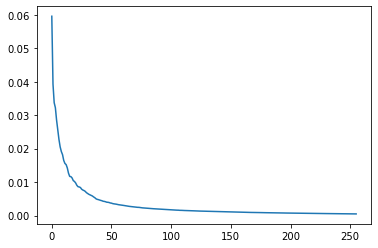

In [27]:
plt.plot(pca.explained_variance_ratio_)
print(np.round(pca.explained_variance_ratio_, decimals=3))
print("Here we see the information (relative %) that each component has.\n" + \
      "The first ones have a lot (14%, 7%, ...) while the other ones have less.\n" + \
      "Only keep the most important")

# Modeling

In [28]:
# build sample classifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.multiclass import OneVsRestClassifier

clf_algo = partial(SVC,C=100 ,kernel="rbf", probability=True, class_weight="balanced")
# partial(KNeighborsClassifier, metric="cosine") # BernoulliNB

In [29]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

#from catboost import CatBoostClassifier
#from lightgbm import LGBMClassifier
#import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier

import pickle


import warnings 
warnings.simplefilter('ignore')

In [30]:
val_proportion = 0.15
np.random.seed(42)

In [31]:
np_labels = np.array(useful_labels)
idxs = {c: np.argwhere(np_labels == c).ravel() for c in np.unique(np_labels)}
idxs_set = {c: {"train": [], "val": []} for c in np.unique(np_labels)}

# random seed so everytime the split is the same
for c in np.unique(np_labels):
    amount = int(len(idxs[c]) * val_proportion)
    choices = np.random.choice(idxs[c], size=amount, replace=False)
    # always check that not all idxs are destined to validation
    if len(choices) < len(idxs[c]):
        # assign the choices to validation and rest to training
        idxs_set[c]["val"]   = choices.tolist()
        idxs_set[c]["train"] = [i for i in idxs[c] if i not in idxs_set[c]["val"]]

# merge indexes for all classes
train_idxs, val_idxs = [], []
for c in np.unique(np_labels):
    val_idxs.extend( idxs_set[c]["val"] ) 
    train_idxs.extend( idxs_set[c]["train"] ) 
    
# get data splitted accordingly:
x_train, y_train = np.array(low_dims)[train_idxs], np.array(useful_labels)[train_idxs]
x_val, y_val     = np.array(low_dims)[val_idxs], np.array(useful_labels)[val_idxs]

# finally, check sizes:
print("Size of training data is: ", len(x_train))
print("Size of validation data is: ", len(x_val))

Size of training data is:  10530
Size of validation data is:  1733


In [ ]:
# get and estimate of how well it'd do on unseen data
clf = clf_algo()
#clf = create_model()
#clf = LGBMClassifier()
#clf = xgb.XGBClassifier()
#clf = OneVsRestClassifier(xgb.XGBClassifier(tree_method='gpu_hist'))
#clf = OneVsRestClassifier(clf_algo())
begin_train = time.time()
clf.fit(x_train, y_train)
end_train = time.time()
print('Training_time :',end_train-begin_train)

begin = time.time()
TOP_K = 3
# for training data
pred_probs_train  = clf.predict_proba(x_train)
in_or_out_train   = []
top_k_preds_train = []
for i,pred in enumerate(pred_probs_train):
    reordered = np.zeros(len(unique_labels))
    reordered[clf.classes_.astype(np.int64)]  = pred
    this_top_k = np.argsort(reordered)[::-1][:TOP_K] 
    top_k_preds_train.append(this_top_k)
    in_or_out_train.append( y_train[i] in this_top_k )


# for validation data
pred_probs_val  = clf.predict_proba(x_val)
in_or_out_val   = []
top_k_preds_val = []
for i,pred in enumerate(pred_probs_val):
    reordered = np.zeros(len(unique_labels))
    reordered[clf.classes_.astype(np.int64)]  = pred
    this_top_k = np.argsort(reordered)[::-1][:TOP_K] 
    top_k_preds_val.append(this_top_k)
    in_or_out_val.append( y_val[i] in this_top_k )
    
# print results
print("A more realistic estimate on training data can be:", np.mean(clf.predict(x_train) == y_train), "in top 1")
print("A more realistic estimate on training data can be:", np.mean(in_or_out_train), "in top", TOP_K, "\n")
print("A more realistic estimate on validation data can be:", np.mean(clf.predict(x_val) == y_val), "in top 1")
print("A more realistic estimate on validation data can be:", np.mean(in_or_out_val), "in top", TOP_K)

# write to file
is_train = []
top_1, top_2, top_3 = [], [], []
for i in range(len(useful_labels)):
    if i in val_idxs:
        is_train.append("val")
        top_1.append( unique_labels[top_k_preds_val[ val_idxs.index(i) ][0]] )
        top_2.append( unique_labels[top_k_preds_val[ val_idxs.index(i) ][1]] )
        top_3.append( unique_labels[top_k_preds_val[ val_idxs.index(i) ][2]] )
    else:
        is_train.append("train")
        top_1.append( unique_labels[top_k_preds_train[ train_idxs.index(i) ][0]] )
        top_2.append( unique_labels[top_k_preds_train[ train_idxs.index(i) ][1]] )
        top_3.append( unique_labels[top_k_preds_train[ train_idxs.index(i) ][2]] )
        
df["first_guess"]  = top_1
df["second_guess"] = top_2
df["third_guess"]  = top_3
df["is_training"] = is_train
df.to_csv("with_predictions.csv")
end = time.time()
print(end - begin)

Training_time : 176.80922865867615
A more realistic estimate on training data can be: 0.8036087369420702 in top 1
A more realistic estimate on training data can be: 0.970275403608737 in top 3 

A more realistic estimate on validation data can be: 0.6393537218695903 in top 1
A more realistic estimate on validation data can be: 0.9036353144835545 in top 3


In [ ]:
pickle.dump(clf, open('svc_model.sav', 'wb'))

In [34]:
from joblib import dump, load
dump(clf, 'clf.joblib') 

['clf.joblib']

In [32]:
from sklearn.model_selection import KFold,StratifiedKFold

In [33]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder() 
df["ICD Block Names"] = le.fit_transform(df["ICD Block Names"]) 

In [34]:
low_dims = pd.DataFrame(low_dims)

In [35]:
#stratified k fold
low_dims["folds"]=-1
kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
for fold, (_, val_index) in enumerate(kf.split(low_dims,df["ICD Block Names"])):
        low_dims.loc[val_index, "folds"] = fold
        df.loc[val_index,"folds"] = fold

In [36]:
def trainn(fold):
    df_train = low_dims[low_dims["folds"] != fold].reset_index(drop=True)
    df_valid = low_dims[low_dims["folds"] == fold].reset_index(drop=True)
    
    target_valid = df[df["folds"]==fold].reset_index(drop=True)
    target_train = df[df["folds"] != fold].reset_index(drop=True)
    
    train_label=target_train["ICD Block Names"]
    valid_label=target_valid["ICD Block Names"]
    
    # get and estimate of how well it'd do on unseen data
    clf = clf_algo()
    #clf = LGBMClassifier()
    #clf = xgb.XGBClassifier()
    #clf = OneVsRestClassifier(xgb.XGBClassifier(tree_method='gpu_hist'))
    #clf = OneVsRestClassifier(clf_algo())
    begin_train = time.time()
    clf.fit(df_train, train_label)
    end_train = time.time()
    print('Training_time :',end_train-begin_train)

    begin = time.time()
    TOP_K = 3
    # for training data
    pred_probs_train  = clf.predict_proba(df_train)
    in_or_out_train   = []
    top_k_preds_train = []
    for i,pred in enumerate(pred_probs_train):
        reordered = np.zeros(len(unique_labels))
        reordered[clf.classes_]  = pred
        this_top_k = np.argsort(reordered)[::-1][:TOP_K] 
        top_k_preds_train.append(this_top_k)
        in_or_out_train.append( train_label[i] in this_top_k )


    # for validation data
    pred_probs_val  = clf.predict_proba(df_valid)
    in_or_out_val   = []
    top_k_preds_val = []
    for i,pred in enumerate(pred_probs_val):
        reordered = np.zeros(len(unique_labels))
        reordered[clf.classes_]  = pred
        this_top_k = np.argsort(reordered)[::-1][:TOP_K] 
        top_k_preds_val.append(this_top_k)
        in_or_out_val.append( valid_label[i] in this_top_k )

    # print results
    print("A more realistic estimate on training data can be:", np.mean(clf.predict(df_train) == train_label), "in top 1")
    print("A more realistic estimate on training data can be:", np.mean(in_or_out_train), "in top", TOP_K, "\n")
    print("A more realistic estimate on validation data can be:", np.mean(clf.predict(df_valid) == valid_label), "in top 1")
    print("A more realistic estimate on validation data can be:", np.mean(in_or_out_val), "in top", TOP_K)

    # write to file
    '''is_train = []
    top_1, top_2, top_3 = [], [], []
    for i in range(len(useful_labels)):
        if i in val_idxs:
            is_train.append("val")
            top_1.append( unique_labels[top_k_preds_val[ val_idxs.index(i) ][0]] )
            top_2.append( unique_labels[top_k_preds_val[ val_idxs.index(i) ][1]] )
            top_3.append( unique_labels[top_k_preds_val[ val_idxs.index(i) ][2]] )
        else:
            is_train.append("train")
            top_1.append( unique_labels[top_k_preds_train[ train_idxs.index(i) ][0]] )
            top_2.append( unique_labels[top_k_preds_train[ train_idxs.index(i) ][1]] )
            top_3.append( unique_labels[top_k_preds_train[ train_idxs.index(i) ][2]] )

    df["first_guess"]  = top_1
    df["second_guess"] = top_2
    df["third_guess"]  = top_3
    df["is_training"] = is_train
    df.to_csv("with_predictions.csv")
    end = time.time()
    print(end - begin)'''

In [37]:
for i in range(1,6):
    trainn(i)

Training_time : 148.11470794677734
A more realistic estimate on training data can be: 0.901223241590214 in top 1
A more realistic estimate on training data can be: 0.9780835881753313 in top 3 

A more realistic estimate on validation data can be: 0.6473705666530779 in top 1
A more realistic estimate on validation data can be: 0.874439461883408 in top 3
Training_time : 153.65838861465454
A more realistic estimate on training data can be: 0.9104994903160041 in top 1
A more realistic estimate on training data can be: 0.9791029561671764 in top 3 

A more realistic estimate on validation data can be: 0.6428862617203425 in top 1
A more realistic estimate on validation data can be: 0.8891153689359967 in top 3
Training_time : 158.20666337013245
A more realistic estimate on training data can be: 0.9118336561002955 in top 1
A more realistic estimate on training data can be: 0.9779838956273571 in top 3 

A more realistic estimate on validation data can be: 0.6431484502446982 in top 1
A more reali

ValueError: Found array with 0 sample(s) (shape=(0, 257)) while a minimum of 1 is required.